# Define the helper functions

In [2]:
interactive_fig = None
interactive_fig_styles = None

def plot_images(images, titles, figure_size):
    #%matplotlib inline
    if interactive_fig is not None:
        plt.close(interactive_fig)
    if interactive_fig_styles is not None:
        plt.close(interactive_fig_styles)
    plt.figure(figsize=(figure_size, figure_size))
    for i in range(len(images)):
        image = images[i]
        title = titles[i]
        plt.subplot(1, len(images), i + 1)
        plt.imshow(image)
        plt.title(title)
        plt.axis('off')

def resize_to(image, target):
    target_height, target_width = target.shape[:2]
    image = cv2.resize(image, (target_width, target_height), interpolation=cv2.INTER_LINEAR)
    return image

def regenerate(org_image, masked_image, mask):
    inverse_mask = cv2.bitwise_not(mask)
    masked_original = cv2.bitwise_and(org_image, org_image, mask=inverse_mask)
    styled_masked = cv2.bitwise_and(masked_image, masked_image, mask=mask)
    return cv2.add(masked_original, styled_masked) 

In [3]:
#from libs.Matrix_masked import MulLayer as MulLayer_m
#from libs.models_masked import encoder4 as encoder_m, decoder4 as decoder_m
#
#enc_ref_m = encoder_m()
#dec_ref_m = decoder_m()
#matrix_ref_m = MulLayer_m('r41')
#
#enc_ref_m.load_state_dict(torch.load('models/vgg_r41.pth'))
#dec_ref_m.load_state_dict(torch.load('models/dec_r41.pth'))
#matrix_ref_m.load_state_dict(torch.load('models/r41.pth',map_location=torch.device('cpu')))
#
#
#def masked_style_transfer(content, style, mask):
#    with torch.no_grad():
#        cF_ref,small_mask = enc_ref_m(content_im,masked_im)
#        sF_ref,_ = enc_ref_m(style_im)
#        feature_ref,transmatrix_ref = matrix_ref_m(cF_ref['r41'],sF_ref['r41'],small_mask)
#        result = dec_ref_m(feature_ref,masked_im)
#        
#    return result

# Define the algorithm functions

In [4]:
import os
import subprocess
from libs.Matrix import MulLayer
from libs.models import encoder4, decoder4
from libs.Matrix_masked import MulLayer as MulLayer_m
from libs.models_masked import encoder4 as encoder_m, decoder4 as decoder_m
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from torchvision import models
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import time
from skimage.feature import local_binary_pattern
from scipy.spatial import distance
from scipy.stats import chisquare
from skimage.color import rgb2lab
from skimage.color import deltaE_ciede2000

def image_to_tensor(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_tensor = F.to_tensor(image)
    image_tensor = image_tensor.unsqueeze(0)
    return image_tensor

def tensor_to_image(tensor):
    if isinstance(tensor, tuple):
        tensor = tensor[0] 
    
    tensor = tensor.squeeze(0) 
    image = tensor.detach().cpu().numpy() 
    image = np.transpose(image, (1, 2, 0))
    image = (image * 255).clip(0, 255).astype(np.uint8) 
    return image

def gram_matrix(features):
    # Assumes flattened input
    b, c, l = features.size()
    G = torch.bmm(features,features.transpose(1,2)) # f: bxcx(hxw), f.transpose: bx(hxw)xc -> bxcxc
    return G.div_(c*l)

def style_loss(features,target,mask):
    ib,ic,ih,iw = features.size()
    iF = features.view(ib,ic,-1)
    imask = mask.view(ib,1,-1)
    iF = iF.masked_select(imask.expand_as(iF) > 0)
    iF = iF.view(ib, ic, -1)
    iMean = torch.mean(iF,dim=2)
    iCov = gram_matrix(iF)

    tb,tc,th,tw = target.size()
    tF = target.view(tb,tc,-1)
    tMean = torch.mean(tF,dim=2)
    tCov = gram_matrix(tF)

    loss = torch.nn.MSELoss(reduction="sum")(iMean,tMean) + torch.nn.MSELoss(reduction="sum")(iCov,tCov)
    return loss/tb

def generate_small_mask(x, mask):
    b, c, h, w = x.shape
    small_mask = mask
    small_mask = torch.nn.functional.interpolate(small_mask, size=(h, w), mode='bilinear', align_corners=False)
    return small_mask.squeeze(0)

def extract_borders(mask, border_thickness, border_type='inner'):
    binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)[1]
    
    kernel = np.ones((border_thickness, border_thickness), np.uint8)
    
    if border_type == 'inner':
        # Erode the mask for inner borders
        eroded_mask = cv2.erode(binary_mask, kernel, iterations=1)
        border_mask = binary_mask - eroded_mask
    elif border_type == 'outer':
        # Dilate the mask for outer borders
        dilated_mask = cv2.dilate(binary_mask, kernel, iterations=1)
        border_mask = dilated_mask - binary_mask
    elif border_type == 'both':
        # Extract both inner and outer borders
        eroded_mask = cv2.erode(binary_mask, kernel, iterations=1)
        inner_border_mask = binary_mask - eroded_mask
        
        dilated_mask = cv2.dilate(binary_mask, kernel, iterations=1)
        outer_border_mask = dilated_mask - binary_mask
        
        # Combine inner and outer borders
        border_mask = cv2.bitwise_or(inner_border_mask, outer_border_mask)
    else:
        raise ValueError("border_type must be either 'inner', 'outer', or 'both'")
    
    return border_mask

def apply_border_mask(image, mask, border_thickness, border_type='inner'):
    border_mask = extract_borders(mask, border_thickness, border_type=border_type)
    border_mask_3channel = cv2.merge([border_mask]*3)
    border_extracted_image = cv2.bitwise_and(image, border_mask_3channel)
    return border_extracted_image

def get_mask_borders(mask, inside_pixels, outside_pixels):
    mask = (mask > 0).astype(np.uint8)
    inside_eroded = cv2.erode(mask, np.ones((inside_pixels, inside_pixels), np.uint8)) if inside_pixels > 0 else mask
    outside_dilated = cv2.dilate(mask, np.ones((outside_pixels, outside_pixels), np.uint8)) if outside_pixels > 0 else mask
    border_mask = outside_dilated - inside_eroded
    return border_mask

def penetrate_mask(mask, radius, shrink=0):
    import scipy.ndimage 
    import numpy as np

    mask = mask.float()
    mask_np = mask.squeeze(0).cpu().numpy() 

    if shrink > 0:
        eroded_mask_np = scipy.ndimage.binary_erosion(mask_np, iterations=shrink).astype(mask_np.dtype)
    else:
        eroded_mask_np = mask_np

    distance_map = scipy.ndimage.distance_transform_edt(eroded_mask_np == 0)
    penetration_mask_np = np.clip((radius - distance_map) / radius, 0, 1)
    penetration_mask = torch.tensor(penetration_mask_np, device=mask.device, dtype=mask.dtype).unsqueeze(0)

    return penetration_mask 

def calculate_gradient_magnitude_around_border(image, mask):
    if len(mask.shape) == 3:
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    
    mask = (mask > 0).astype(np.uint8)
    
    grad_magnitudes = []
    for c in range(3): 
        grad_x = cv2.Sobel(image[:, :, c], cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(image[:, :, c], cv2.CV_64F, 0, 1, ksize=3)
        grad_magnitude = np.sqrt(grad_x**2 + grad_y**2)
        grad_magnitudes.append(grad_magnitude)
    
    # Combine gradient magnitudes across channels
    gradient_magnitude = np.mean(grad_magnitudes, axis=0)
    
    # Apply the mask to isolate the border
    border_gradient_magnitude = gradient_magnitude * mask
    border_pixels = border_gradient_magnitude[mask > 0]

    mean_gradient = np.mean(border_pixels)
    std_gradient = np.std(border_pixels)
    median_gradient = np.median(border_pixels)
    return mean_gradient, std_gradient, median_gradient

def calculate_texture_continuity(blended_image, inner_border_mask, outer_border_mask, radius=1, n_points=8):
    # Ensure masks are binary
    inner_border_mask = (inner_border_mask > 0).astype(np.uint8)
    outer_border_mask = (outer_border_mask > 0).astype(np.uint8)
    
    lbp_histograms_inner = []
    lbp_histograms_outer = []
    
    # Process each color channel
    for c in range(3):  # For each color channel (assuming BGR format)
        channel_image = blended_image[:, :, c]
        lbp_image = local_binary_pattern(channel_image, n_points, radius, method='uniform')
        
        # Extract LBP values within the inner and outer masks
        inner_area = lbp_image[inner_border_mask > 0]
        outer_area = lbp_image[outer_border_mask > 0]
        
        # Calculate histograms for each channel
        bins = np.arange(0, n_points + 3)
        inner_hist, _ = np.histogram(inner_area, bins=bins)
        outer_hist, _ = np.histogram(outer_area, bins=bins)
        
        lbp_histograms_inner.append(inner_hist)
        lbp_histograms_outer.append(outer_hist)
    
    # Combine histograms from all channels
    inner_hist_total = np.concatenate(lbp_histograms_inner)
    outer_hist_total = np.concatenate(lbp_histograms_outer)
    
    # Normalize histograms
    eps = 1e-10
    inner_hist_total = inner_hist_total.astype(np.float32)
    outer_hist_total = outer_hist_total.astype(np.float32)
    inner_hist_total /= (inner_hist_total.sum() + eps)
    outer_hist_total /= (outer_hist_total.sum() + eps)
    
    # Compute Chi-square distance
    chi2_distance = 0.5 * np.sum(((inner_hist_total - outer_hist_total) ** 2) / (inner_hist_total + outer_hist_total + eps))
    
    return chi2_distance

def calculate_color_continuity(image, border_mask):
    # Ensure border_mask is binary
    border_mask = (border_mask > 0).astype(np.uint8)

    # Get coordinates of border pixels
    border_coords = np.column_stack(np.where(border_mask == 1))

    # Convert image to LAB color space for perceptual color difference
    image_lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

    # Initialize list to store color differences
    color_differences = []

    # Define 8-connected neighborhood offsets
    offsets = [(-1, -1), (-1, 0), (-1, 1),
               (0, -1),          (0, 1),
               (1, -1),  (1, 0), (1, 1)]

    # Iterate over each border pixel
    for y, x in border_coords:
        pixel_color = image_lab[y, x, :]  # Border pixel color in LAB

        # Find neighboring pixels outside the border mask
        for dy, dx in offsets:
            ny, nx = y + dy, x + dx

            # Check if neighbor is within image bounds
            if 0 <= ny < border_mask.shape[0] and 0 <= nx < border_mask.shape[1]:
                # Check if neighbor is outside the border mask
                if border_mask[ny, nx] == 0:
                    neighbor_color = image_lab[ny, nx, :]

                    # Compute color difference (CIEDE2000)
                    deltaE = deltaE_ciede2000(pixel_color[np.newaxis, :], neighbor_color[np.newaxis, :])[0]

                    color_differences.append(deltaE)
                    break  # Only consider the first neighbor across the border

    # Convert list to NumPy array
    color_differences = np.array(color_differences)

    # Handle case with no color differences
    if len(color_differences) == 0:
        mean_color_difference = 0
        std_color_difference = 0
        median_color_difference = 0
    else:
        # Compute statistics
        mean_color_difference = np.mean(color_differences)
        std_color_difference = np.std(color_differences)
        median_color_difference = np.median(color_differences)

    return mean_color_difference, std_color_difference, median_color_difference

enc_ref = encoder4()
dec_ref = decoder4()
matrix_ref = MulLayer('r41')

enc_ref.load_state_dict(torch.load('./models/vgg_r41.pth'))
dec_ref.load_state_dict(torch.load('./models/dec_r41.pth'))
matrix_ref.load_state_dict(torch.load('./models/r41.pth',map_location=torch.device('cpu')))

enc_ref_m = encoder_m()
dec_ref_m = decoder_m()
matrix_ref_m = MulLayer_m('r41')

enc_ref_m.load_state_dict(torch.load('models/vgg_r41.pth'))
dec_ref_m.load_state_dict(torch.load('models/dec_r41.pth'))
matrix_ref_m.load_state_dict(torch.load('models/r41.pth', map_location=torch.device('cpu')))

def style_transfer(content_im, style_im):
    with torch.no_grad():
        cF_ref = enc_ref(image_to_tensor(content_im))
        sF_ref = enc_ref(image_to_tensor(style_im))
        feature_ref, transmatrix_ref = matrix_ref(cF_ref['r41'], sF_ref['r41'])
        result = dec_ref(feature_ref)
    return tensor_to_image(result)

#def partial_convolution(content_im, mask, style_image_file):
#    masked_im = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
#    style_im = cv2.imread(style_image_file)
#    
#    with torch.no_grad():
#        content_tensor = image_to_tensor(content_im)
#        style_tensor = image_to_tensor(style_im)
#        mask_tensor = image_to_tensor(masked_im)
#        mask_tensor = mask_tensor[:, 0:1, :, :]
#        
#        cF_ref, small_mask = enc_ref_m(content_tensor, mask_tensor)
#        sF_ref, _ = enc_ref_m(style_tensor)
#        feature_ref, transmatrix_ref = matrix_ref_m(cF_ref['r41'], sF_ref['r41'], small_mask)
#        result = dec_ref_m(feature_ref, mask_tensor)
#        
#    processed_image_rgb = tensor_to_image(result)
#    processed_image_rgb = resize_to(processed_image_rgb, content_im)
#    processed_image_rgb = regenerate(cv2.cvtColor(content_im, cv2.COLOR_BGR2RGB), processed_image_rgb, mask)
#    return processed_image_rgb

def partial_convolution(content_im, mask, style_image_file, feathering=False, penetrate_initial_mask_pixels=0, cookie_cutter=False):
    def visualize_masks(mask_tensors, titles=None, figsize=(12, 6)):
        num_masks = len(mask_tensors)
        titles = titles or [f'Mask {i+1}' for i in range(num_masks)]

        plt.figure(figsize=figsize)

        for i, mask_tensor in enumerate(mask_tensors):
            mask_np = mask_tensor.cpu().numpy()
            mask_np = mask_np.squeeze() 

            plt.subplot(1, num_masks, i + 1)
            plt.imshow(mask_np, cmap='gray')
            plt.title(titles[i])
            plt.axis('off')

        plt.tight_layout()
        plt.show()

    def visualize_feature_maps(feature_maps, titles, rows=2, cols=5):
        plt.figure(figsize=(15, 6))
        for i, feature_map in enumerate(feature_maps):
            plt.subplot(rows, cols, i + 1)
            feature_map_np = feature_map[0, 222].cpu().detach().numpy()
            plt.imshow(feature_map_np, cmap='viridis')
            plt.title(titles[i])
            plt.axis('off')
        plt.tight_layout()
        plt.show()
        
    def resize_style_image_to_mask(mask, style_im):
        if len(mask.shape) == 3 and mask.shape[2] == 3:
            gray_mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY) 
        else:
            gray_mask = mask 

        _, binary_mask = cv2.threshold(gray_mask, 1, 255, cv2.THRESH_BINARY)

        non_zero_pixels = cv2.findNonZero(binary_mask)  # Find all non-zero pixel coordinates
        x, y, w, h = cv2.boundingRect(non_zero_pixels)  # Compute bounding box (x, y, width, height)
        style_h, style_w = style_im.shape[:2]
        scale_factor = min(h / style_h, w / style_w)
        new_style_h = int(style_h * scale_factor)
        new_style_w = int(style_w * scale_factor)
        resized_style_im = cv2.resize(style_im, (new_style_w, new_style_h), interpolation=cv2.INTER_AREA)
        return resized_style_im
    
    def blend_styled_edges(original_image, styled_image, mask, alpha=0.5):
        if isinstance(mask, torch.Tensor):
            mask = mask.squeeze().cpu().numpy()

        if mask.shape[:2] != original_image.shape[:2]:
            mask = cv2.resize(mask, (original_image.shape[1], original_image.shape[0]), interpolation=cv2.INTER_NEAREST)

        if len(mask.shape) == 3 and mask.shape[2] == 1:
            mask = mask.squeeze(axis=2)
        elif len(mask.shape) == 3 and mask.shape[2] != 1:
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        elif len(mask.shape) != 2:
            raise ValueError("Mask must be 2D or 3D with one channel.")

        if mask.max() <= 1:
            mask = (mask * 255).astype(np.uint8)
        else:
            mask = mask.astype(np.uint8)

        original_image = original_image.astype(np.uint8)
        styled_image = styled_image.astype(np.uint8)
            
        inverse_mask = cv2.bitwise_not(mask)

        inverse_masked_original = cv2.bitwise_and(original_image, original_image, mask=inverse_mask)
        inverse_masked_original_bordered = apply_border_mask(inverse_masked_original, inverse_mask, 5, border_type='inner')

        masked_styled = cv2.bitwise_and(styled_image, styled_image, mask=mask)
        inverse_masked_styled = cv2.bitwise_and(styled_image, styled_image, mask=inverse_mask)
        masked_styled_outer = apply_border_mask(inverse_masked_styled, mask, 5, border_type='outer')

        blended_image = cv2.addWeighted(masked_styled_outer, alpha, inverse_masked_original_bordered, 1 - alpha, 0)
        blended_image += inverse_masked_original - inverse_masked_original_bordered
        blended_image += masked_styled

        return blended_image

    masked_im = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    style_im = cv2.imread(style_image_file)
    #style_im = resize_style_image_to_mask(mask, style_im)
    
    with torch.no_grad():
        content_tensor = image_to_tensor(content_im)
        style_tensor = image_to_tensor(style_im)

        mask_tensor = image_to_tensor(masked_im)
        mask_tensor = mask_tensor[:, 0:1, :, :]
        
        if penetrate_initial_mask_pixels > 0:
            cF_ref, small_mask = enc_ref_m(content_tensor, penetrate_mask(mask_tensor, penetrate_initial_mask_pixels), cookie_cutter=cookie_cutter)
        else:
            cF_ref, small_mask = enc_ref_m(content_tensor, mask_tensor, cookie_cutter=cookie_cutter)
                
        sF_ref, _ = enc_ref_m(style_tensor)
        
        feature_ref, _ = matrix_ref_m(cF_ref['r41'], sF_ref['r41'], small_mask)
        
        result, mask_conv11, mask_conv12, mask_conv13, mask_conv14, mask_conv15, \
        mask_conv16, mask_conv17, mask_conv18, mask_conv19, out11, out12, out13, \
        out14, out15, out16, out17, out18, out19 = dec_ref_m(
            feature_ref, 
            small_mask, 
            feathering=feathering, 
            cookie_cutter=cookie_cutter
        )
        
    processed_image_rgb = tensor_to_image(result)
    processed_image_rgb = resize_to(processed_image_rgb, content_im)
    if feathering:
        processed_image_rgb = blend_styled_edges(cv2.cvtColor(content_im, cv2.COLOR_BGR2RGB), processed_image_rgb, mask, alpha=0.5)
    else:
        processed_image_rgb = regenerate(cv2.cvtColor(content_im, cv2.COLOR_BGR2RGB), processed_image_rgb, mask)
    
    ### GRADIENT MAGNITUDE
    mean, std, median = calculate_gradient_magnitude_around_border(processed_image_rgb, get_mask_borders(mask, 2, 5))
    
    ### TEXTURE CONTINUITY
    mask_borders_inner = get_mask_borders(mask, 5, 0)
    mask_borders       = get_mask_borders(mask, 0, 5)
    mask_borders_outer = get_mask_borders(mask, 5, 7)
    texture_continuity_1 = calculate_texture_continuity(processed_image_rgb, mask_borders_inner, mask_borders)
    texture_continuity_2 = calculate_texture_continuity(processed_image_rgb, mask_borders, mask_borders_outer)
    sum_text_continuity = texture_continuity_1 + texture_continuity_2
    
    ### COLOR CONTINUITY
    mean_cc, std_cc, median_cc = calculate_color_continuity(processed_image_rgb, get_mask_borders(mask, 2, 5))
    sum_color_continuity = round(mean_cc, 2) + round(std_cc, 2)
    
    print(f'{i} - {round(mean, 2)} - {round(std, 2)} - {round(texture_continuity_1, 4)} - {round(texture_continuity_2, 4)} - {round(sum_text_continuity, 4)} - {round(mean_cc, 2)} - {round(std_cc, 2)} - {sum_color_continuity}')
    
    total_style_loss = 0.0  
    style_layers = ['r11','r21','r31','r41']
    image_tensor = image_to_tensor(processed_image_rgb)  
    tF, _ = enc_ref_m(image_tensor, mask_tensor) 
    
    for layer in style_layers:
        sf_i = sF_ref[layer]
        sf_i = sf_i.detach() 
        tf_i = tF[layer]
        small_mask = generate_small_mask(tf_i, mask_tensor)
        total_style_loss += style_loss(tf_i, sf_i, small_mask)
    
    #print("Total Style Loss:", total_style_loss.item())
    
    return processed_image_rgb
    

def style_and_mask(image, mask, style_image_file):
    styled_image = style_transfer(image, cv2.imread(style_image_file))
    
    ### resize styled image to original size    
    org_styled_image = resize_to(styled_image, image)
    
    return regenerate(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), org_styled_image, mask)

def mask_and_style(image, mask, style_image_file):
    masked_image_file = './output/masked.jpg'
    masked_styled_image_file = './output/masked-styled.jpg'
    
    ### mask the original image
    masked_image = cv2.bitwise_and(image, image, mask=mask)

    ### style the masked image
    masked_styled_image = style_transfer(masked_image, cv2.imread(style_image_file))
    
    ### resize styled image to original size    
    resized_masked_styled_image = resize_to(masked_styled_image, image)

    ### regenerating masked-style image
    return regenerate(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), resized_masked_styled_image, mask)

def bbox_mask_and_style(image, mask, style_image_file):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    bboxed_image_file = './output/bboxed-masked.jpg'
    bboxed_styled_image_file = './output/bboxed-masked-style.jpg'

    bbox = masks[mask_index]['bbox']

    ### bbox and mask the original image
    x, y, w, h = bbox
    bboxed_mask = mask[y:y+h, x:x+w]
    original_bboxed_image = image[y:y+h, x:x+w]
    masked_bboxed_image = cv2.bitwise_and(original_bboxed_image, original_bboxed_image, mask=bboxed_mask)
    
    ### style the bboxed image
    bboxed_styled_image = style_transfer(masked_bboxed_image, cv2.imread(style_image_file))
    
    ### resize masked styled image
    bboxed_styled_image = cv2.resize(bboxed_styled_image, (w, h))
    masked_styled_bboxed_image = cv2.bitwise_and(bboxed_styled_image, bboxed_styled_image, mask=bboxed_mask)

    ### regenerating bboxed styles original image
    inverse_mask = cv2.bitwise_not(bboxed_mask)
    masked_original_bboxed_image = cv2.bitwise_and(original_bboxed_image, original_bboxed_image, mask=inverse_mask)
    
    final_bboxed_masked_styled_image = cv2.add(masked_styled_bboxed_image, masked_original_bboxed_image) 
    
    ### inject styled bboxed image into original image
    bbox_masked_styled_image = cv2.cvtColor(cv2.imread(original_image_name), cv2.COLOR_BGR2RGB)
    bbox_masked_styled_image[y:y+h, x:x+w] = final_bboxed_masked_styled_image 
    return bbox_masked_styled_image

def bbox_style_and_mask(image, mask, style_image_file):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    bboxed_image_file = './output/bboxed-masked.jpg'
    bboxed_styled_image_file = './output/bboxed-styled-masked.jpg'

    bbox = masks[mask_index]['bbox']
    x, y, w, h = bbox
    original_bboxed_image = image[y:y+h, x:x+w]
    bboxed_mask = mask[y:y+h, x:x+w]

    ### style the bboxed image
    bboxed_styled_image = style_transfer(original_bboxed_image, cv2.imread(style_image_file))
    
    ### mask the styled bboxed image
    bboxed_styled_image = cv2.resize(bboxed_styled_image, (w, h))
    bboxed_styled_masked_image = cv2.bitwise_and(bboxed_styled_image, bboxed_styled_image, mask=bboxed_mask)
    
    ### regenerating bboxed styles original image
    inverse_mask = cv2.bitwise_not(bboxed_mask)
    masked_original_bboxed_image = cv2.bitwise_and(original_bboxed_image, original_bboxed_image, mask=inverse_mask)
    final_bboxed_masked_styled_image = cv2.add(masked_original_bboxed_image, bboxed_styled_masked_image) 
    
    ### inject styled bboxed image into original image
    bbox_masked_styled_image = cv2.cvtColor(cv2.imread(original_image_name), cv2.COLOR_BGR2RGB)
    bbox_masked_styled_image[y:y+h, x:x+w] = final_bboxed_masked_styled_image 
    return bbox_masked_styled_image
    

# Define the variables

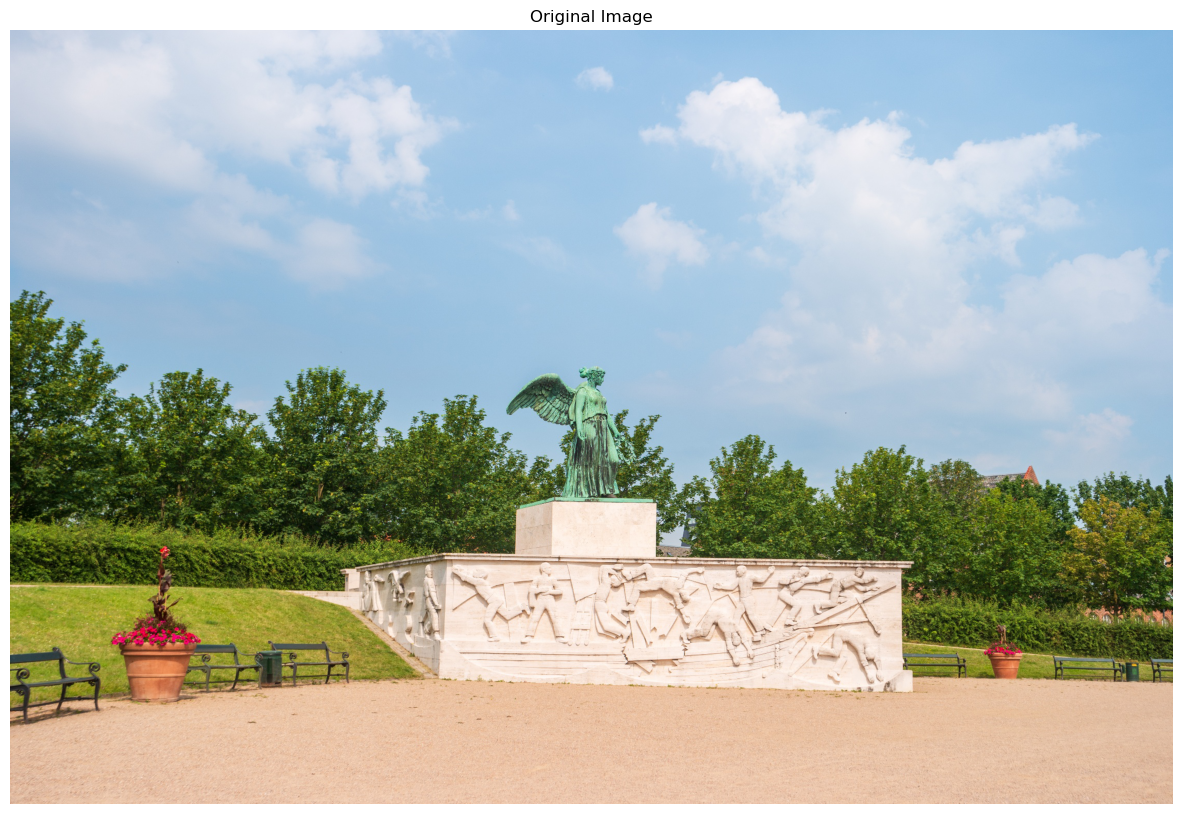

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

linear_style_transfer_file = '/Users/ayberk.cansever/Documents/ECU/Thesis/LinearStyleTransfer/linearstyletransfer.py'
#original_image_name = './sources/image-2.png'
original_image_name = './paper_dataset/sa_5.jpg'

image = cv2.imread(original_image_name)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plot_images([image], ['Original Image'], 15)


# Create SAM mask generator

In [7]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device=torch.device('mps' if torch.cuda.is_available() else 'cpu')
print(device)

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

cpu


# Create masks

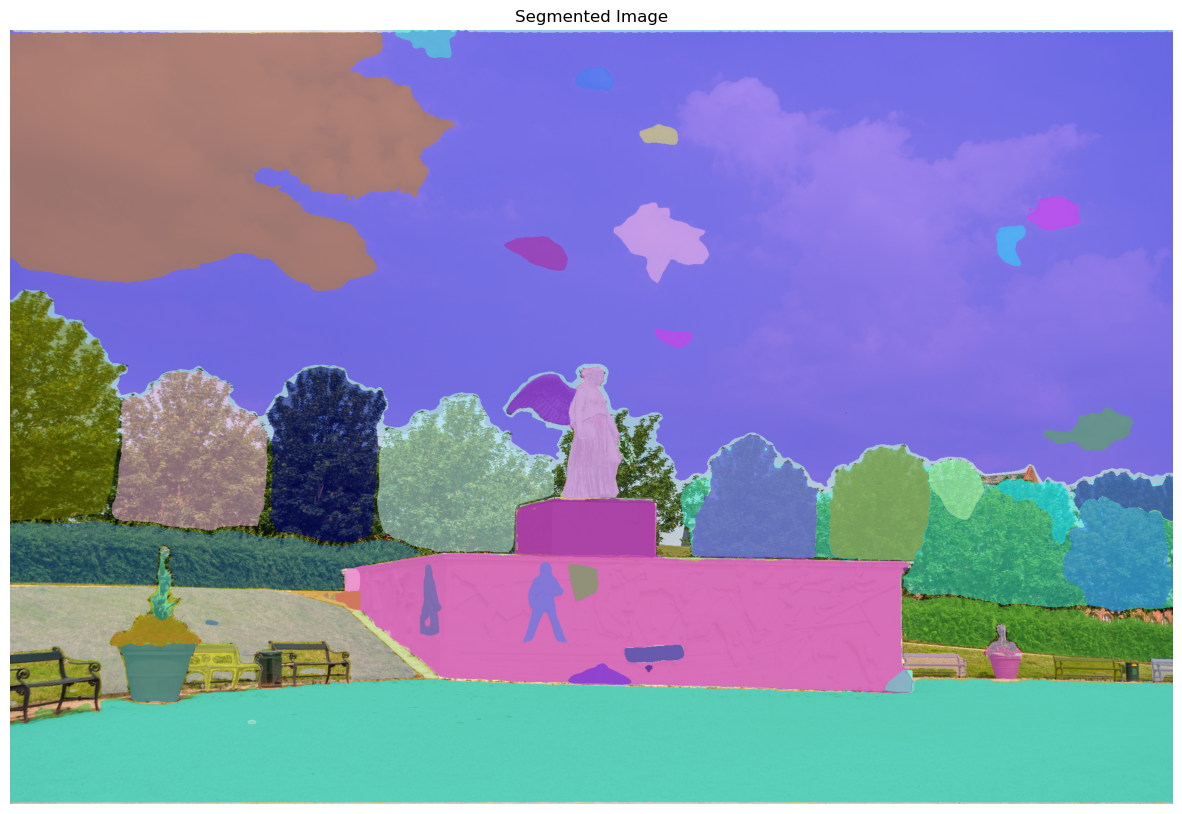

In [9]:
import pickle
import supervision as sv

#masks = mask_generator.generate(image)

#with open('paper_sa_8.pkl', 'wb') as file:
#    pickle.dump(masks, file)
#print(masks[0].keys())

with open('paper_sa_5.pkl', 'rb') as file:
    masks = pickle.load(file)

segmented_masks = [
    mask['segmentation']
    for mask in masks
]

mask_annotator = sv.MaskAnnotator()
detections = sv.Detections.from_sam(sam_result=masks)

annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
plot_images([annotated_image], ['Segmented Image'], 15)


# Select Mask

Button(description='Save Selected Mask', style=ButtonStyle())

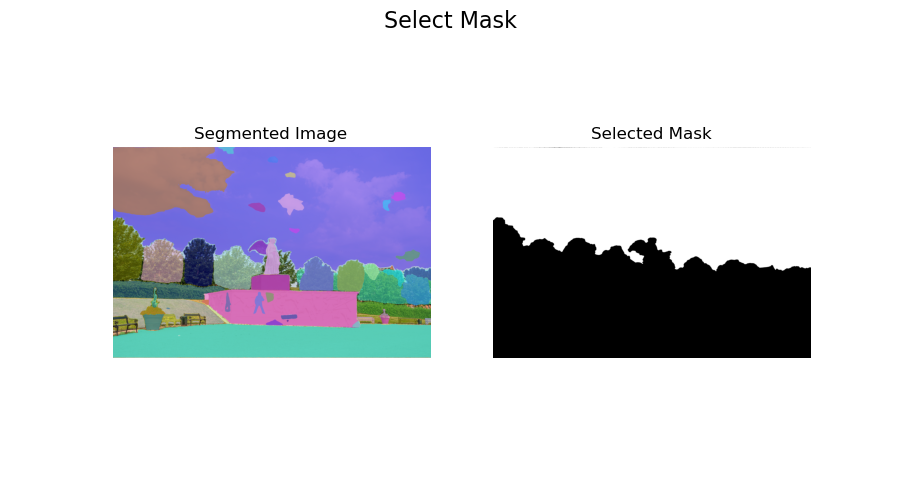

In [11]:
%matplotlib widget
import matplotlib.pyplot as plt
import ipympl


import numpy as np
import cv2
import ipywidgets as widgets

mask_index = 0
mask = (segmented_masks[mask_index] * 255).astype(np.uint8) 

interactive_fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
interactive_fig.suptitle('Select Mask', fontsize=16)

implot1 = ax1.imshow(annotated_image)
ax1.set_title('Segmented Image')
ax1.axis('off')
implot2 = ax2.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
ax2.set_title('Selected Mask')
ax2.axis('off')

def onclick(event):
    global mask 
    global mask_index
    if event.xdata is not None and event.ydata is not None:
        x = int(event.xdata)
        y = int(event.ydata)
        pixel_value = annotated_image[y, x]
        for index, segmented_mask in enumerate(segmented_masks):
            new_mask = (segmented_mask * 255).astype(np.uint8)
            pixel_value = new_mask[y, x]
            if pixel_value == 255:
                mask = (segmented_masks[index] * 255).astype(np.uint8) 
                #mask = np.ones_like(segmented_masks[index], dtype=np.uint8) * 255
                mask_index = index
                implot2.set_data(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
                interactive_fig.canvas.draw_idle()
                break

implot1.figure.canvas.mpl_connect('button_press_event', onclick)

save_button = widgets.Button(description="Save Selected Mask")

# Define the callback function
def on_save_clicked(b):
    filename = f"selected_mask_{mask_index}.png"
    cv2.imwrite(filename, mask)
    print(f"Mask saved as {filename}")

# Link button to callback
save_button.on_click(on_save_clicked)

# Display the button in the notebook
display(save_button)


# Select Style

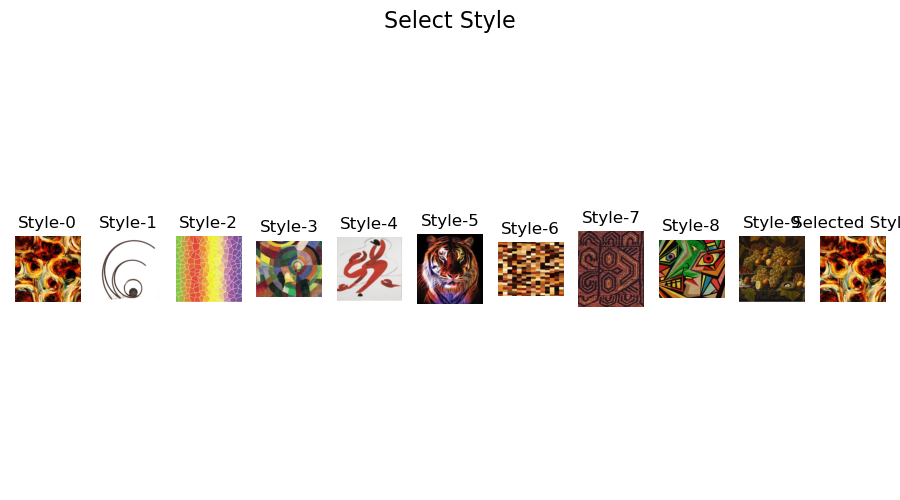

In [18]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import cv2
from IPython.display import display
import ipywidgets as widgets

style_images = [cv2.cvtColor(cv2.imread(f'./styles/style-{i}.jpg'), cv2.COLOR_BGR2RGB) for i in range(10)]

interactive_fig_styles, axs = plt.subplots(1, 11, figsize=(9, 5))
interactive_fig_styles.suptitle('Select Style', fontsize=16)

image_titles = ['Style-0', 'Style-1', 'Style-2', 'Style-3', 'Style-4', 'Style-5', 'Style-6', 'Style-7', 'Style-8', 'Style-9', 'Selected Style']

for i, ax in enumerate(axs[:-1]):
    ax.imshow(style_images[i])
    ax.set_title(image_titles[i])
    ax.axis('off')

ax_st_selected = axs[-1]
implot_st_selected = ax_st_selected.imshow(style_images[0])
ax_st_selected.set_title(image_titles[-1])
ax_st_selected.axis('off')
style_image_file = f'./styles/style-0.jpg'

def onclick_style(event):
    global style_image_file
    for i, ax in enumerate(axs[:-1]):
        if event.inaxes == ax:
            axs[-1].clear() 
            axs[-1].imshow(style_images[i])
            axs[-1].set_title(image_titles[-1]) 
            axs[-1].axis('off')
            style_image_file = f'./styles/style-{i}.jpg'
            break
    interactive_fig_styles.canvas.draw_idle()

interactive_fig_styles.canvas.mpl_connect('button_press_event', onclick_style)

plt.tight_layout() 
plt.show()

# Select Algorithm

In [19]:
algorithms=['Style And Mask', 'Mask And Style', 'BBox Style and Mask', 'BBox Mask and Style', 'Partial Convolution']
dropdown = widgets.Dropdown(
    options=algorithms,  
    value='Style And Mask',
    description='Algorithm:',
    disabled=False,
)
display(dropdown)

Dropdown(description='Algorithm:', options=('Style And Mask', 'Mask And Style', 'BBox Style and Mask', 'BBox M…

# Process

Partial Convolution processing...


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


9 - 117.2 - 92.27 - 0.0211 - 0.0033 - 0.0244 - 12.91 - 12.65 - 25.560000000000002


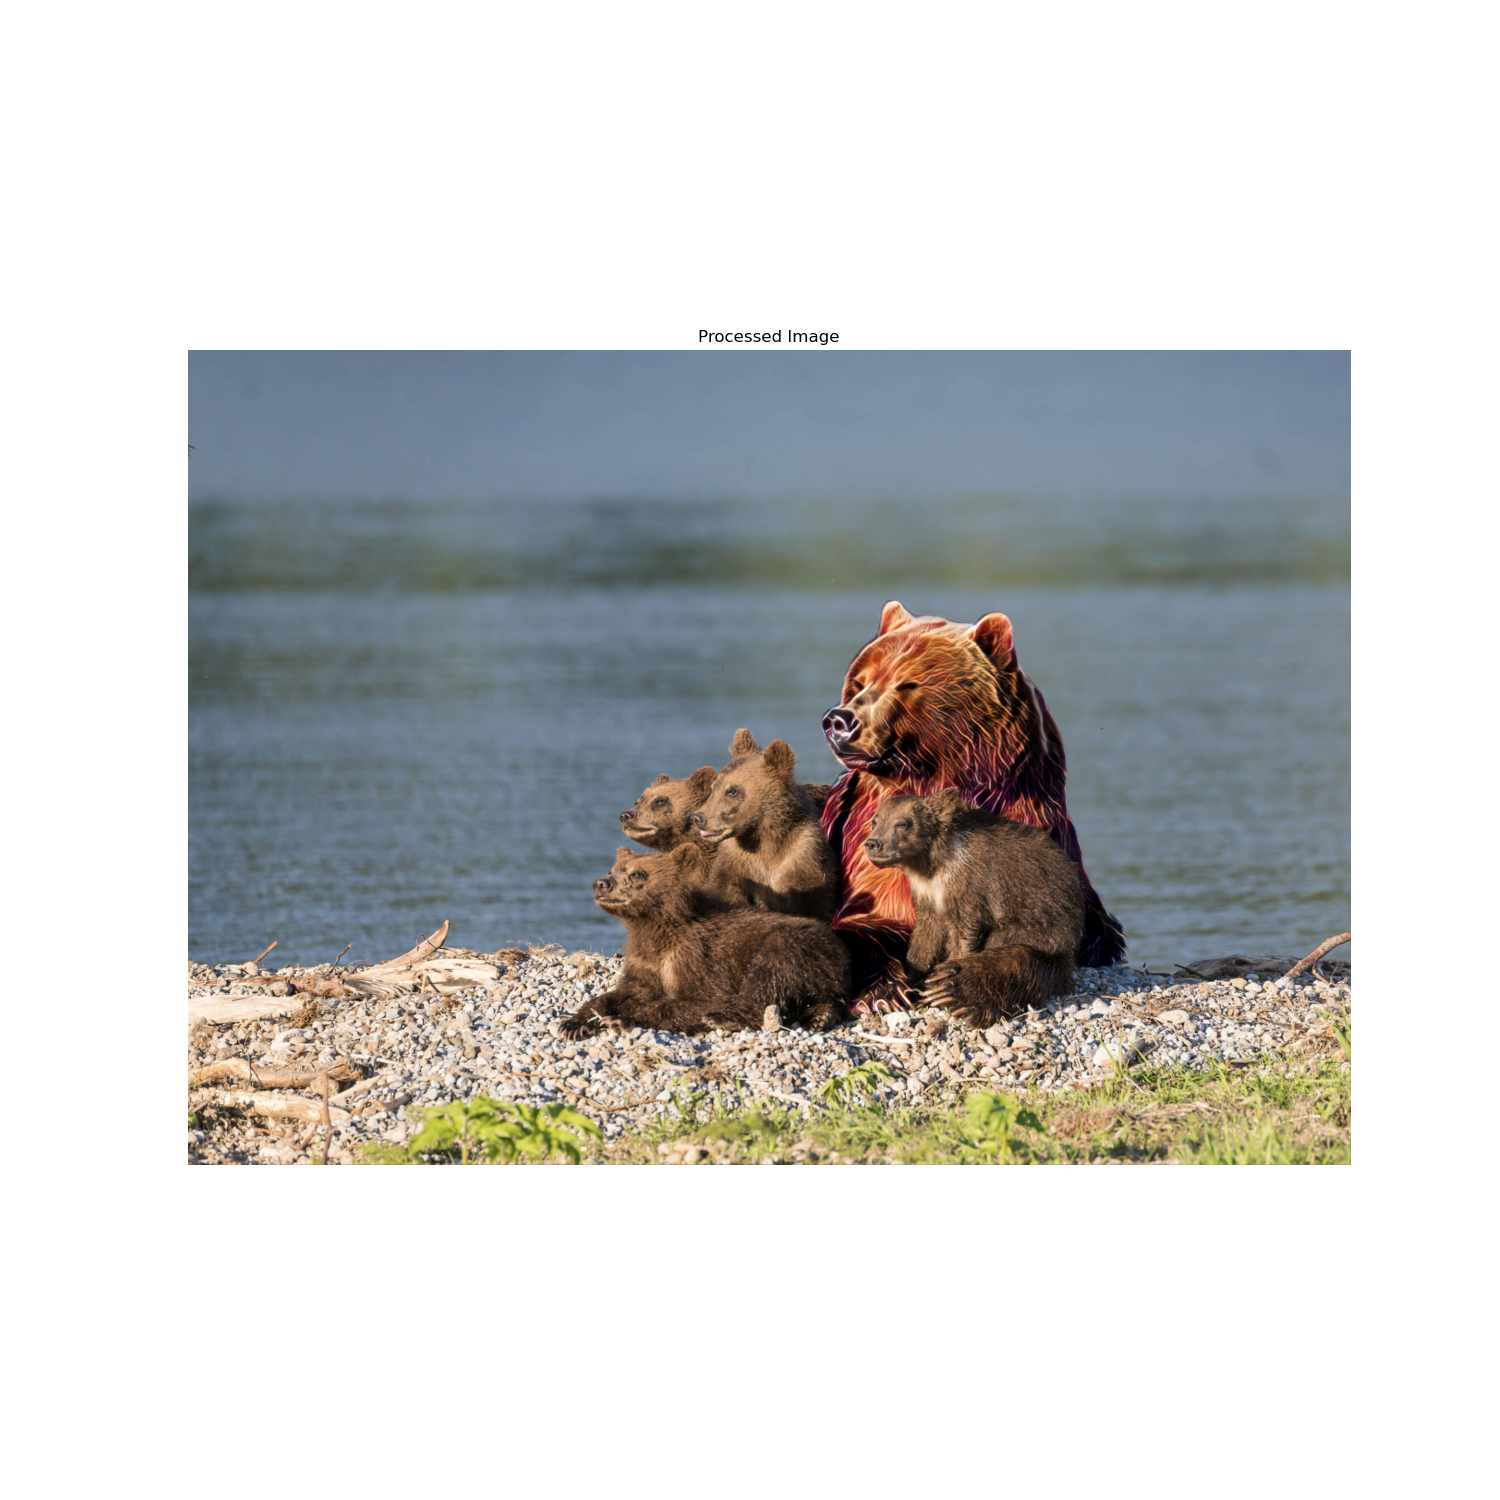

In [22]:
import numpy as np

selected_index = dropdown.index
algorithm = algorithms[selected_index]
print(f'{algorithm} processing...')

processed_image_filename = 'processed_image.jpg'

#os.remove('processed_image.jpg')

if os.path.isfile(processed_image_filename):
    image_to_be_processed = cv2.imread(processed_image_filename)
else:
    image_to_be_processed = cv2.imread(original_image_name)

if selected_index == 0:
    processed_image = style_and_mask(image_to_be_processed, mask, style_image_file)
elif selected_index == 1:
    processed_image = mask_and_style(image_to_be_processed, mask, style_image_file)
elif selected_index == 2:
    processed_image = bbox_style_and_mask(image_to_be_processed, mask, style_image_file)
elif selected_index == 3:
    processed_image = bbox_mask_and_style(image_to_be_processed, mask, style_image_file)
elif selected_index == 4:
    processed_image = partial_convolution(image_to_be_processed, mask, style_image_file,
                                            feathering=True, 
                                            penetrate_initial_mask_pixels=9,
                                            cookie_cutter=True)
    
processed_image_rgb = cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB)
cv2.imwrite('processed_image.jpg', processed_image_rgb) 
cv2.imwrite('mask.jpg', mask) 

plot_images([processed_image], ['Processed Image'], 15)


# Gatys Style Transfer Implementation With Mask

Content Image Size: torch.Size([1, 3, 1500, 2247])
Style Image Size: torch.Size([1, 3, 256, 256])
Mask Image Size: torch.Size([1, 1, 1500, 2247])


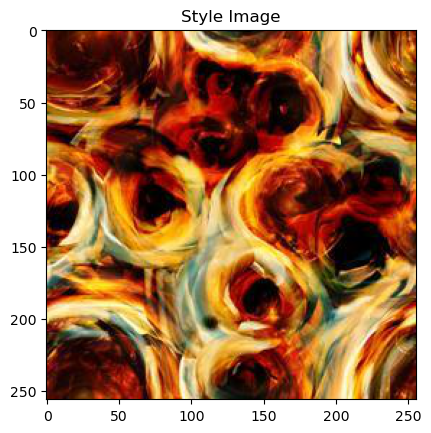

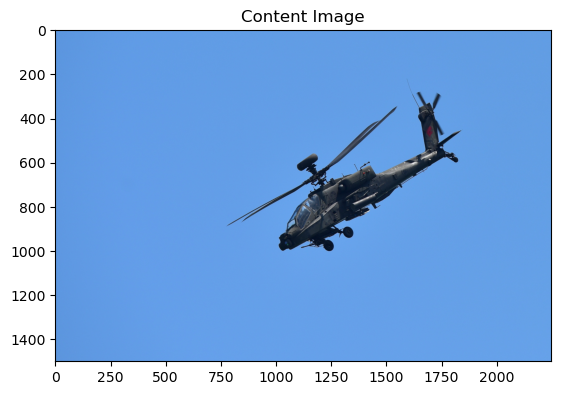

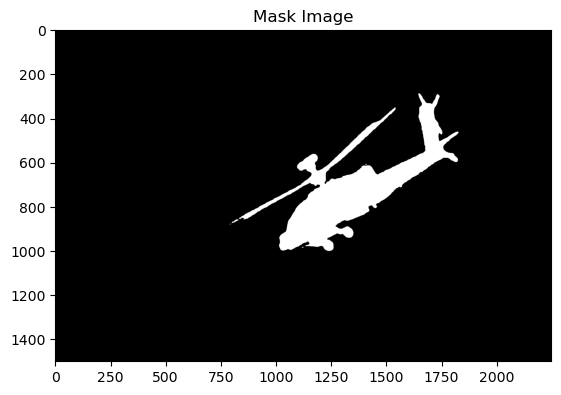

Building the style transfer model...
Optimizing...
run 10:
Style Loss : 21.784963607788086 Content Loss: 0.8897544741630554
Step Duration: 24.3745 seconds
run 20:
Style Loss : 11.612481117248535 Content Loss: 1.2824124097824097
Step Duration: 24.1030 seconds
run 30:
Style Loss : 7.045523643493652 Content Loss: 1.429949402809143
Step Duration: 24.9986 seconds
run 40:
Style Loss : 4.411912441253662 Content Loss: 1.4796202182769775
Step Duration: 24.8639 seconds
run 50:
Style Loss : 2.9288899898529053 Content Loss: 1.510779619216919
Step Duration: 23.6629 seconds
run 60:
Style Loss : 2.152306318283081 Content Loss: 1.48126220703125
Step Duration: 23.3952 seconds
run 70:
Style Loss : 1.7190238237380981 Content Loss: 1.4301074743270874
Step Duration: 23.1424 seconds
run 80:
Style Loss : 1.3809058666229248 Content Loss: 1.400638222694397
Step Duration: 23.2416 seconds
run 90:
Style Loss : 1.1991389989852905 Content Loss: 1.3705002069473267
Step Duration: 23.0887 seconds
run 100:
Style Loss :

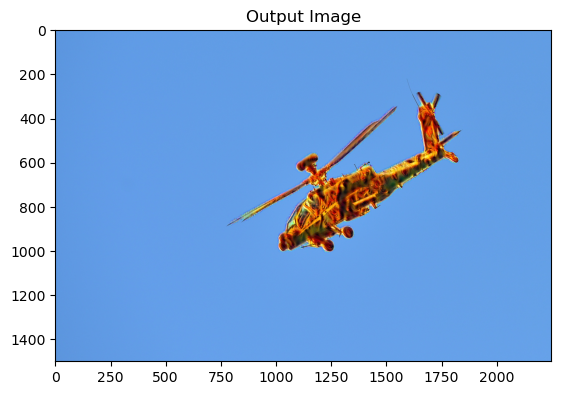

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights
import numpy as np
import copy
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loader = transforms.Compose([
    transforms.ToTensor(),
])

def image_loader(image_name, target_size=None):
    image = Image.open(image_name).convert('RGB')
    if target_size:
        image = image.resize((target_size[1], target_size[0]), Image.LANCZOS)

    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

def mask_array_to_tensor(mask_array, target_size=None):
    mask = Image.fromarray(mask_array.astype(np.uint8))

    if target_size:
        mask = mask.resize((target_size[1], target_size[0]), Image.NEAREST)

    mask = transforms.ToTensor()(mask).unsqueeze(0).to(device)
    mask = (mask > 0.5).float()
    return mask

content_image_file = "paper_dataset/sa_8.jpg"
content_img = image_loader(content_image_file)
content_size = content_img.size(2), content_img.size(3)  # (height, width)

style_image_file = "paper_dataset/27.jpg"
style_img = image_loader(style_image_file)

print("Content Image Size:", content_img.size())  # Should be [1, 3, H, W]
print("Style Image Size:", style_img.size())

mask_png_file = "paper_dataset/sa_8_mask.png"
mask_pil = Image.open(mask_png_file).convert("L")
mask_array = np.array(mask_pil)
#mask_array = mask  
mask_img = mask_array_to_tensor(mask_array, target_size=content_size)

print("Mask Image Size:", mask_img.size())  # Should be [1, 1, H, W]
assert mask_img.size(2) == content_img.size(2) and mask_img.size(3) == content_img.size(3), \
    "Mask and content images must have the same dimensions!"

unloader = transforms.ToPILImage()  

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image, cmap='gray' if tensor.size(0) == 1 else None)
    if title:
        plt.title(title)
    plt.pause(0.001)

plt.figure()
imshow(style_img, title='Style Image')
plt.figure()
imshow(content_img, title='Content Image')
plt.figure()
imshow(mask_img, title='Mask Image')

# Loss functions
class ContentLoss(nn.Module):
    def __init__(self, target, mask):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
        self.mask = mask

    def forward(self, input):
        # Dynamically resize the target feature map to match the input feature map
        target_resized = torch.nn.functional.interpolate(self.target, size=input.shape[-2:], mode='bilinear', align_corners=False)
        # Resize the mask to match the input feature map
        mask_resized = torch.nn.functional.interpolate(self.mask, size=input.shape[-2:], mode='bilinear', align_corners=False)

        # Compute loss
        self.loss = torch.nn.functional.mse_loss(input * mask_resized, target_resized * mask_resized)
        return input

def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):
    def __init__(self, target_feature, mask):
        super(StyleLoss, self).__init__()
        self.target = target_feature.detach()
        self.mask = mask

    def forward(self, input):
        # Dynamically resize the target feature map and mask
        target_resized = torch.nn.functional.interpolate(self.target, size=input.shape[-2:], mode='bilinear', align_corners=False)
        mask_resized = torch.nn.functional.interpolate(self.mask, size=input.shape[-2:], mode='bilinear', align_corners=False)

        # Compute Gram matrices for the masked regions
        G = gram_matrix(input * mask_resized)
        target_gram = gram_matrix(target_resized * mask_resized)

        # Compute loss
        self.loss = torch.nn.functional.mse_loss(G, target_gram)
        return input

# Model and normalization
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.to(device).eval() 
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = mean.view(-1, 1, 1)
        self.std = std.view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img, mask_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    normalization = Normalization(normalization_mean, normalization_std).to(device)
    content_losses = []
    style_losses = []
    model = nn.Sequential(normalization)
    i = 0

    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        else:
            raise RuntimeError(f'Unrecognized layer: {layer.__class__.__name__}')

        model.add_module(name, layer)

        if name in content_layers:
            # Extract content features
            target = model(content_img).detach()
            content_loss = ContentLoss(target, mask_img)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # Extract style features
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature, mask_img)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    # Trim off layers after the last content and style loss
    for j in range(len(model) - 1, -1, -1):
        if isinstance(model[j], ContentLoss) or isinstance(model[j], StyleLoss):
            break

    model = model[:(j + 1)]
    model.to(device)
    return model, style_losses, content_losses

def get_input_optimizer(input_img):
    input_img.requires_grad_(True)
    optimizer = optim.LBFGS([input_img])
    return optimizer

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, mask_img, input_img,
                       num_steps=100, style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model...')
    model, style_losses, content_losses = get_style_model_and_losses(
        cnn, normalization_mean, normalization_std, style_img, content_img, mask_img)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing...')
    run = [0]
    total_start_time = time.time()

    while run[0] <= num_steps:
        def closure():
            step_start_time = time.time()

            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            step_end_time = time.time()

            if run[0] % 10 == 0:
                print(f"run {run[0]}:")
                print(f'Style Loss : {style_score.item()} Content Loss: {content_score.item()}')
                print(f"Step Duration: {step_end_time - step_start_time:.4f} seconds")

                # Save intermediate image
                with torch.no_grad():
                    img = input_img.clone()
                    img = img.squeeze(0).cpu()
                    unloader = transforms.ToPILImage()
                    img = unloader(img.clamp_(0, 1))
                    img.save(f"output_step_{run[0]}.jpg")

            return loss

        optimizer.step(closure)

    total_end_time = time.time()
    print(f"Total Optimization Duration: {total_end_time - total_start_time:.4f} seconds")

    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

# Run the style transfer
input_img = content_img.clone()
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, mask_img, input_img)

plt.figure()
imshow(output, title='Output Image')
plt.ioff()
plt.show()